In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.autograd import grad
from torch import nn, optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torch.optim.lr_scheduler import MultiStepLR
from torchvision.utils import make_grid
from torchvision import transforms as torch_transforms

In [2]:
import sys
sys.path.append("./../../")

from modules.dvae.model import DVAE
from modules.dvae.funcs import ng_quantize

from notebooks.utils import show

from datasets.mnist_loader import MNISTData

In [3]:
def subsequent_mask(sz):
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1).float()
    mask = mask.masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

In [4]:
class Config:
    DEVICE                      = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    num_labels                  = 10
    
    img_channels                = 1
    vocab_size                  = 32
    
    hidden_height               = 14
    hidden_width                = 14

    num_blocks                  = 12
    n_attn_heads                = 8
    hidden_dim                  = 256
    dropout_prob                = 0.1

    dvae_num_x2upsamples        = 2
    dvae_num_resids_downsample  = 3
    dvae_num_resids_bottleneck  = 4
    dvae_hidden_dim             = 256

    mnist_type                  = "classic_56"
    root_img_path               = "/m/home/home8/82/sukhoba1/data/Desktop/TA-VQVAE/data/MNIST/"
    
    load_dvae_path              = "/m/home/home8/82/sukhoba1/data/Desktop/TA-VQVAE/models/mnist/dvae_vocab32_mnist56/"
    dvae_model_name             = "dvae_vocab32_mnist56"
    
    model_path                  = "/m/home/home8/82/sukhoba1/data/Desktop/TA-VQVAE/models/mnist/dtr_generator_v3_mnist56/"
    model_name                  = "dtr_generator_v3_mnist56"
    
    NUM_EPOCHS                  = 30
    BATCH_SIZE                  = 128
    LR                          = 0.01
    LR_gamma                    = 0.1
    step_LR_milestones          = [5, 15, 25]


CONFIG = Config()

In [5]:
data_source = MNISTData(
    img_type=CONFIG.mnist_type,
    root_path=CONFIG.root_img_path,
    batch_size=CONFIG.BATCH_SIZE)
train_loader = data_source.get_train_loader()

In [6]:
class TrEncoderBlock(nn.Module):
    def __init__(self, n_features, n_attn_heads, n_hidden=64, dropout_prob=0.1):
        super(TrEncoderBlock, self).__init__()

        self.attn = nn.MultiheadAttention(n_features, n_attn_heads)
        self.ln1 = nn.LayerNorm(n_features)
        self.dropout1 = nn.Dropout(dropout_prob)

        self.mlp = nn.Sequential(
            nn.Linear(n_features, n_hidden),
            nn.Dropout(dropout_prob),
            nn.GELU(),
            nn.Linear(n_hidden, n_features)
        )
        self.ln2 = nn.LayerNorm(n_features)
        self.dropout2 = nn.Dropout(dropout_prob)

    def forward(self, x, pad_mask=None, attn_mask=None):
        xn = self.ln1(x)
        dx, _ = self.attn(query=xn, key=xn, value=xn, 
                          key_padding_mask=pad_mask, 
                          attn_mask=attn_mask)
        x = x + self.dropout1(dx)
        
        xn = self.ln2(x)
        dx = self.mlp(xn)
        x = x + self.dropout2(dx)
        
        return x

In [7]:
class TrDecoderBlock(nn.Module):
    def __init__(self, n_features, n_attn_heads, n_hidden=64, dropout_prob=0.1):
        super(TrDecoderBlock, self).__init__()

        self.self_attn = nn.MultiheadAttention(n_features, n_attn_heads)
        self.ln1 = nn.LayerNorm(n_features)
        self.dropout1 = nn.Dropout(dropout_prob)

        self.cross_attn = nn.MultiheadAttention(n_features, n_attn_heads)
        self.ln2 = nn.LayerNorm(n_features)
        self.dropout2 = nn.Dropout(dropout_prob)

        self.mlp = nn.Sequential(
            nn.Linear(n_features, n_hidden),
            nn.Dropout(dropout_prob),
            nn.ReLU(),
            nn.Linear(n_hidden, n_features)
        )
        self.ln3 = nn.LayerNorm(n_features)
        self.dropout3 = nn.Dropout(dropout_prob)

    def forward(self, x, y, pad_mask=None, attn_mask=None):
        xn = self.ln1(x)
        dx, self_attn_map = self.self_attn(query=xn, key=xn, value=xn, attn_mask=attn_mask)
        x = x + self.dropout1(dx)
        
        xn = self.ln2(x)
        dx, cross_attn_map = self.cross_attn(query=xn, key=y, value=y)
        x = x + self.dropout2(dx)
        
        xn = self.ln3(x)
        dx = self.mlp(xn)
        x = x + self.dropout3(dx)
        return x, self_attn_map, cross_attn_map

In [8]:
class LabelEmbedding(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super(LabelEmbedding, self).__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
    
    def forward(self, label):
        return self.embedding(label)

In [9]:
class Generator(nn.Module):
    def __init__(self,
                 hidden_width,
                 hidden_height,
                 embedding_dim,
                 num_blocks,
                 num_embeddings,
                 hidden_dim,
                 n_attn_heads,
                 dropout_prob):
        super(Generator, self).__init__()

        self.hidden_width = hidden_width
        self.hidden_height = hidden_height
        self.embedding_dim = embedding_dim
        seq_len = hidden_width * hidden_height
        
        self.proj_in = nn.Linear(embedding_dim, embedding_dim)
        self.proj_out = nn.Linear(embedding_dim, embedding_dim)
        
        self.pe_col = nn.Parameter(torch.randn(hidden_width, 1, embedding_dim))
        self.pe_row = nn.Parameter(torch.randn(hidden_height, 1, embedding_dim))
        self.enc_params = nn.Parameter(torch.randn(seq_len, 1, embedding_dim))
        self.pe_enc_start = nn.Parameter(torch.randn(1, 1, embedding_dim))
             
        self.tr_enc_blocks = nn.ModuleList([
            TrEncoderBlock(
                n_features=embedding_dim,
                n_attn_heads=n_attn_heads,
                n_hidden=hidden_dim,
                dropout_prob=dropout_prob)
            for _ in range(num_blocks)
        ])
        
        self.tr_dec_blocks = nn.ModuleList([
            TrDecoderBlock(
                n_features=embedding_dim,
                n_attn_heads=n_attn_heads,
                n_hidden=hidden_dim,
                dropout_prob=dropout_prob)
            for _ in range(num_blocks)
        ])
        
        self.label_embedding = LabelEmbedding(
            num_embeddings=num_embeddings,
            embedding_dim=embedding_dim)

    def forward(self, x, label, noise):
        seq_len, batch, emb = x.size()
        mask = subsequent_mask(seq_len).to(x.device)
        x = self.proj_in(x)
        
        pe_column = self.pe_col.repeat(self.hidden_width, 1, 1)
        pe_row = self.pe_row.repeat_interleave(self.hidden_height, dim=0)
        x = x + pe_column + pe_row
        
        pe_enc_column = torch.cat([self.pe_enc_start, pe_column], dim=0)
        pe_enc_row = torch.cat([self.pe_enc_start, pe_row], dim=0)
        enc_params = self.enc_params.repeat(1, batch, 1)
        noise_emb = torch.cat([noise, enc_params], dim=0)
        noise_emb = noise_emb + pe_enc_column + pe_enc_row
        
        for i, block in enumerate(self.tr_enc_blocks):
            noise_emb = block(noise_emb)
        
        label_emb = self.label_embedding(label)
        label_emb = label_emb.unsqueeze(0)
        
        num_dec_noise_blocks = len(self.tr_dec_blocks) // 3
        for i, block in enumerate(self.tr_dec_blocks):
            if i < num_dec_noise_blocks:
                x, _, _ = block(x, noise_emb[1:, :, :], attn_mask=mask)
            else:
                x, _, _ = block(x, label_emb, attn_mask=mask)
        
        x = self.proj_out(x)
        return x
    
    def save_model(self, root_path, model_name):
        if not os.path.exists(root_path):
            os.makedirs(root_path)
        path = os.path.join(root_path, model_name + ".pth")
        torch.save(self.state_dict(), path)
    
    def load_model(self, root_path, model_name, map_location=torch.device('cpu')):
        path = os.path.join(root_path, model_name + ".pth")
        self.load_state_dict(torch.load(path, map_location=map_location))

In [10]:
dvae = DVAE(
    in_channels=CONFIG.img_channels,
    vocab_size=CONFIG.vocab_size,
    num_x2downsamples=CONFIG.dvae_num_x2upsamples,
    num_resids_downsample=CONFIG.dvae_num_resids_downsample,
    num_resids_bottleneck=CONFIG.dvae_num_resids_bottleneck,
    hidden_dim=CONFIG.dvae_hidden_dim)

G = Generator(
    hidden_width=CONFIG.hidden_width,
    hidden_height=CONFIG.hidden_height,
    embedding_dim=CONFIG.vocab_size,
    num_blocks=CONFIG.num_blocks,
    num_embeddings=CONFIG.num_labels,
    hidden_dim=CONFIG.hidden_dim,
    n_attn_heads=CONFIG.n_attn_heads,
    dropout_prob=CONFIG.dropout_prob)

optimizer = optim.Adam(G.parameters(), lr=CONFIG.LR)

lr_scheduler = MultiStepLR(optimizer, milestones=CONFIG.step_LR_milestones, gamma=CONFIG.LR_gamma)

In [11]:
dvae.eval()
G.train()

dvae.load_model(
    root_path=CONFIG.load_dvae_path,
    model_name=CONFIG.dvae_model_name)

# G.load_model(
#     root_path=CONFIG.model_path,
#     model_name=CONFIG.model_name)

dvae.to(CONFIG.DEVICE)
G.to(CONFIG.DEVICE)

pass

In [13]:
print("Device in use: {}".format(CONFIG.DEVICE))

criteriation = nn.CrossEntropyLoss()

iteration = 0
for epoch in range(CONFIG.NUM_EPOCHS):
    for img, label in train_loader:
        label = label.to(CONFIG.DEVICE)
        img = img.to(CONFIG.DEVICE)
        
        current_batch_dim = img.size(0)
        noise = torch.randn(1, current_batch_dim, CONFIG.vocab_size, device=CONFIG.DEVICE)

        with torch.no_grad():
            latent = dvae.ng_q_encode(img)

        b, emb, h, w = latent.size()
        x = latent.view(b, emb, -1).permute(2, 0, 1)
        
        start_vector = torch.zeros(1, b, emb, device=x.device)
        x_strat_seq = torch.cat([start_vector, x[:-1,:,:]], dim=0)
        x_end_seq = x
        
        output = G(x_strat_seq, label, noise)
        
        seq_labels_pred = output.view(-1, emb)
        seq_lables_true = x_end_seq.argmax(dim=2).view(-1)
        
        loss = criteriation(seq_labels_pred, seq_lables_true)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        iteration += 1

        if iteration % 55 == 0:
            print("Epoch: {} Iter: {} Loss: {}".format(epoch, iteration, round(loss.item(), 5)))
    
    lr_scheduler.step()

G.save_model(CONFIG.model_path, CONFIG.model_name)

Device in use: cuda
Epoch: 0 Iter: 55 Loss: 1.09756
Epoch: 0 Iter: 110 Loss: 0.80154
Epoch: 0 Iter: 165 Loss: 0.7073
Epoch: 0 Iter: 220 Loss: 0.67063
Epoch: 0 Iter: 275 Loss: 0.64782
Epoch: 0 Iter: 330 Loss: 0.58044
Epoch: 0 Iter: 385 Loss: 0.58697
Epoch: 0 Iter: 440 Loss: 0.56109
Epoch: 1 Iter: 495 Loss: 0.5366
Epoch: 1 Iter: 550 Loss: 0.5376
Epoch: 1 Iter: 605 Loss: 0.52089
Epoch: 1 Iter: 660 Loss: 0.49573
Epoch: 1 Iter: 715 Loss: 0.47318
Epoch: 1 Iter: 770 Loss: 0.48137
Epoch: 1 Iter: 825 Loss: 0.48191
Epoch: 1 Iter: 880 Loss: 0.46273
Epoch: 1 Iter: 935 Loss: 0.42047
Epoch: 2 Iter: 990 Loss: 0.45271
Epoch: 2 Iter: 1045 Loss: 0.43598
Epoch: 2 Iter: 1100 Loss: 0.45123
Epoch: 2 Iter: 1155 Loss: 0.40695
Epoch: 2 Iter: 1210 Loss: 0.44828
Epoch: 2 Iter: 1265 Loss: 0.41845
Epoch: 2 Iter: 1320 Loss: 0.42334
Epoch: 2 Iter: 1375 Loss: 0.40199
Epoch: 3 Iter: 1430 Loss: 0.41879
Epoch: 3 Iter: 1485 Loss: 0.39375
Epoch: 3 Iter: 1540 Loss: 0.39785
Epoch: 3 Iter: 1595 Loss: 0.39341
Epoch: 3 Iter: 1

Epoch: 27 Iter: 13035 Loss: 0.32969
Epoch: 27 Iter: 13090 Loss: 0.32361
Epoch: 28 Iter: 13145 Loss: 0.32435
Epoch: 28 Iter: 13200 Loss: 0.32634
Epoch: 28 Iter: 13255 Loss: 0.31778
Epoch: 28 Iter: 13310 Loss: 0.33302
Epoch: 28 Iter: 13365 Loss: 0.32025
Epoch: 28 Iter: 13420 Loss: 0.32937
Epoch: 28 Iter: 13475 Loss: 0.3131
Epoch: 28 Iter: 13530 Loss: 0.31717
Epoch: 28 Iter: 13585 Loss: 0.3387
Epoch: 29 Iter: 13640 Loss: 0.33142
Epoch: 29 Iter: 13695 Loss: 0.33307
Epoch: 29 Iter: 13750 Loss: 0.32404
Epoch: 29 Iter: 13805 Loss: 0.3296
Epoch: 29 Iter: 13860 Loss: 0.32677
Epoch: 29 Iter: 13915 Loss: 0.30665
Epoch: 29 Iter: 13970 Loss: 0.31823
Epoch: 29 Iter: 14025 Loss: 0.33308


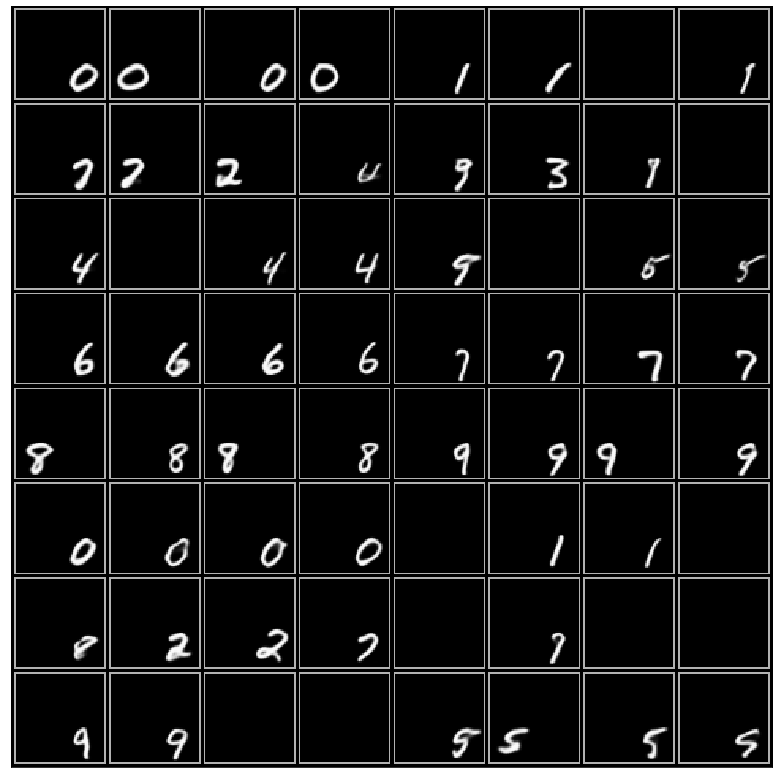

In [18]:
hidden_width = CONFIG.hidden_width
hidden_height = CONFIG.hidden_height
seq_len = hidden_width * hidden_height
embedding_dim = CONFIG.vocab_size
batch_size = 64

samples = torch.zeros(seq_len + 1, batch_size, embedding_dim).to(CONFIG.DEVICE)

sample_labels = torch.LongTensor([
    0, 0, 0, 0, 1, 1, 1, 1,
    2, 2, 2, 2, 3, 3, 3, 3,
    4, 4, 4, 4, 5, 5, 5, 5,
    6, 6, 6, 6, 7, 7, 7, 7,
    8, 8, 8, 8, 9, 9, 9, 9,
    0, 0, 0, 0, 1, 1, 1, 1,
    2, 2, 2, 2, 3, 3, 3, 3,
    4, 4, 4, 4, 5, 5, 5, 5
]).to(CONFIG.DEVICE)

sample_noise = torch.randn(1, batch_size, CONFIG.vocab_size, device=CONFIG.DEVICE)

with torch.no_grad():
    for i in range(seq_len):
        out = G(samples[:-1,:,:], sample_labels, sample_noise)
        
        z = ng_quantize(out, dim=-1)
        one_hot_sample = z[i,:,:]

        samples[i+1, :, :] = one_hot_sample

latent_x = samples[1:, :, :].view(hidden_height, hidden_width, batch_size, embedding_dim).permute(2, 3, 0, 1)

with torch.no_grad():
    gen_img = dvae.decode(latent_x)

show(gen_img, figsize=(14,14), plot_grid=True)

In [13]:
# img, label = next(iter(train_loader))

# label = label.to(CONFIG.DEVICE)
# img = img.to(CONFIG.DEVICE)

# t = dvae.ng_q_encode(img)
# t_ = dvae.decode(t)

# print(t.shape)

# show(t_[:8, :, :, :])

In [30]:
!nvidia-smi

Tue May 18 17:15:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.03   Driver Version: 450.119.03   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro P5000        Off  | 00000000:02:00.0 Off |                  Off |
| 26%   36C    P8     6W / 180W |   9371MiB / 16277MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------